<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Замена-англицизмов" data-toc-modified-id="Замена-англицизмов-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Замена англицизмов</a></span></li><li><span><a href="#Замена-числительных" data-toc-modified-id="Замена-числительных-2.0.0.3"><span class="toc-item-num">2.0.0.3&nbsp;&nbsp;</span>Замена числительных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.0.0.4"><span class="toc-item-num">2.0.0.4&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Подготовка-корпуса" data-toc-modified-id="Подготовка-корпуса-2.0.0.5"><span class="toc-item-num">2.0.0.5&nbsp;&nbsp;</span>Подготовка корпуса</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Тематическое-моделирвование" data-toc-modified-id="Тематическое-моделирвование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тематическое моделирвование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LSI" data-toc-modified-id="LSI-3.0.0.1"><span class="toc-item-num">3.0.0.1&nbsp;&nbsp;</span>LSI</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3.0.0.2"><span class="toc-item-num">3.0.0.2&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-3.0.0.3"><span class="toc-item-num">3.0.0.3&nbsp;&nbsp;</span>Визуализация</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Импорт библиотек

In [1]:
import pandas as pd
import re
import json
import glob
from sklearn.feature_extraction.text import CountVectorizer

#spacy
import spacy
import nltk
from nltk.corpus import stopwords 

import numpy as np
from pymystem3 import Mystem
m = Mystem() 
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import gensim.corpora as corpora
import gensim.models


#Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel




#vis
import pyLDAvis
import pyLDAvis.gensim_models


#warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Подготовка данных

In [2]:
#Добавим функцию для чтения json
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

#### Загрузка датасета

In [3]:
#Прочитаем датасет

df1=pd.read_excel("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\parsing_result (12-02-2022).xlsx")

#### Замена англицизмов

In [4]:
%%time
df_engl=pd.read_csv("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\Anglicisms(04-01-2022).csv",encoding = 'cp1251',sep=';')
df_engl
df_engl=df_engl.drop(['Unnamed: 0'], axis=1)
df_engl.columns=df_engl.columns.str.lower()
df_engl
df_engl['english']=df_engl['english'].str.lower()
df_engl

Wall time: 3.99 ms


,english,russian
0,bloomberg,блумберг
1,covid-19,ковид девятнадцать
2,group-ib,групп айби
3,fox,фокс
4,sun,сан
...,...,...
72,instagram,инстаграм
73,james,джеймс
74,foreign,форейн
75,google,гугл


In [5]:
df_engl_dict=df_engl.set_index('english').T.to_dict('records')

In [6]:
df_engl_dict=df_engl_dict[0]

In [7]:
def replace_from_dict(str,dict):
    for i in (str.split(" ")):
        for j in dict.keys():
            if i==j:
                #print(i)
                str=str.replace(i,dict.get(j))
    return str

In [8]:
#Очистим текст от лишних символов
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Zа-яА-я0-9 ]', ' ', text).split())  
clear_text('hill: сенат сша проголосует по вопросу санкций против «северного потока — 2» до 14 января')

'hill сенат сша проголосует по вопросу санкций против северного потока 2 до 14 января'

In [9]:
df1['TITLE']=df1['TITLE'].apply(lambda x: clear_text(x))
df1['TITLE']=df1['TITLE'].apply(lambda x: replace_from_dict(x,df_engl_dict))

#### Замена числительных

In [10]:
%%time
df_numbers=pd.read_csv("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\Numbers(05-01-2022).csv",encoding = 'cp1251',sep=';')
df_numbers
df_numbers=df_numbers.drop(['Unnamed: 0'], axis=1)
df_numbers


Wall time: 2.99 ms


,number,word
0,1,один
1,2,два
2,3,три
3,4,четыре
4,5,пять
...,...,...
340,NaN,NaN
341,NaN,NaN
342,NaN,NaN
343,NaN,NaN


In [11]:
df_numbers=df_numbers.set_index('number').T.to_dict('records')
df_numbers_dict=df_numbers[0]

<ipython-input-11-4f619f413480>:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_numbers=df_numbers.set_index('number').T.to_dict('records')


In [12]:
df1['TITLE']=df1['TITLE'].apply(lambda x: replace_from_dict(x,df_numbers_dict))

#### Лемматизация

In [13]:
#Напишем фукнцию лемматизации
def lemmatization(texts):
    nlp = spacy.load("ru_core_news_sm")
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [14]:
%%time
lemmatized_texts=lemmatization(df1['TITLE'])
print(lemmatized_texts[0:10])

100%|███████████████████████████████████████████████████████████████████████████| 19576/19576 [02:35<00:00, 126.14it/s]

['из шахта в кузбасс после авария эвакуировать сто двадцать горняк', 'роспотребнадзор изучать возможность введение штраф за отказ от вакцинация', 'грушко предложение россия по гарантия безопасность не содержать скрытый повестка', 'министр оборона фрг призвать направить санкция против руководство россия', 'карнаухов и маннинен стать хороший игрок матч россия финляндия', 'минобороны показать видео уничтожение боевик в сирия дрон ланцет в два тысяча двадцать год', 'умереть режиссёр фильм мы из будущее андрей малюков', 'мвд объяснить сбой в регистрационный система гибдд затопление серверный помещение', 'кристина резцова завоевать бронза в масс старт на этап кубок мир по биатлон в анси', 'американский сенатор поругаться из за северный поток два']
Wall time: 2min 36s


#### Подготовка корпуса

In [15]:
corpus=np.array(lemmatized_texts)
len(corpus)

19576

In [16]:
stop_words = set(stopwords.words('russian')) 

custom_stopwords = set(['это','весь','яя','ая','га','свой','спрашивать','становиться','отвечать','подходить','уходить','выходить','оставаться','разговор','ехать','приходить'])
stop_words.update(custom_stopwords)
additional_stopwords= set(['двадцать','глава','тысяча','год'])
stop_words.update(additional_stopwords)


In [17]:
#Удалим стоп-слова
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

tokenized_texts = [list(tokenize(text.lower()))for text in corpus]
tokenized_texts_processed= remove_stopwords(tokenized_texts)
dictionary= Dictionary(tokenized_texts_processed)
corpus= [dictionary.doc2bow(text) for text in tokenized_texts_processed]
#corpus

# Тематическое моделирвование

#### LSI

In [18]:
model = LsiModel (corpus=corpus, num_topics=2, id2word=dictionary)
model.print_topics()

[(0,
  '0.758*"россия" + 0.323*"украина" + 0.318*"сша" + 0.202*"заявить" + 0.134*"путин" + 0.124*"мид" + 0.106*"президент" + 0.105*"нато" + 0.092*"безопасность" + 0.091*"санкция"'),
 (1,
  '0.590*"россия" + -0.545*"украина" + -0.277*"заявить" + -0.271*"сша" + -0.235*"путин" + -0.187*"рф" + -0.157*"президент" + 0.090*"сборная" + -0.080*"мид" + -0.061*"ситуация"')]

In [19]:
def compute_coherence_values_lsi(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

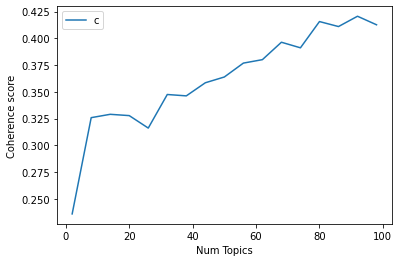

Wall time: 2min 33s


In [20]:
%%time
model_list, coherence_values = compute_coherence_values_lsi(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.figsize=(20,4)
plt.show()

In [21]:
model=LsiModel(corpus=corpus, id2word=dictionary, num_topics=10)
model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.758*"россия" + 0.323*"украина" + 0.318*"сша" + 0.202*"заявить" + 0.134*"путин"'),
 (1,
  '-0.590*"россия" + 0.545*"украина" + 0.277*"заявить" + 0.271*"сша" + 0.235*"путин"'),
 (2,
  '0.626*"путин" + 0.355*"заявить" + -0.328*"сша" + -0.326*"украина" + 0.286*"президент"'),
 (3,
  '-0.675*"сша" + 0.562*"украина" + -0.182*"безопасность" + -0.177*"путин" + 0.159*"заявить"'),
 (4,
  '0.576*"заявить" + -0.464*"путин" + 0.346*"девятнадцать" + 0.345*"covid" + -0.226*"президент"'),
 (5,
  '-0.560*"заявить" + 0.507*"covid" + 0.506*"девятнадцать" + 0.180*"украина" + 0.087*"москва"'),
 (6,
  '-0.767*"казахстан" + 0.241*"путин" + -0.236*"президент" + -0.179*"мид" + 0.166*"заявить"'),
 (7,
  '0.452*"против" + -0.433*"мид" + 0.402*"санкция" + -0.316*"безопасность" + -0.288*"нато"'),
 (8,
  '-0.489*"рф" + -0.391*"мид" + -0.386*"против" + 0.325*"сша" + -0.316*"санкция"'),
 (9,
  '-0.481*"газ" + -0.469*"европа" + -0.326*"российский" + 0.268*"президент" + -0.218*"цена"')]

#### LDA

In [22]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.038*"россия" + 0.026*"украина" + 0.019*"сша" + 0.018*"путин" + 0.017*"заявить" + 0.012*"олимпиада" + 0.010*"мид" + 0.010*"рф" + 0.009*"президент" + 0.008*"назвать"'),
 (1,
  '0.013*"февраль" + 0.012*"covid" + 0.011*"девятнадцать" + 0.009*"москва" + 0.009*"пять" + 0.007*"восемь" + 0.006*"дело" + 0.006*"россиянин" + 0.006*"жириновский" + 0.005*"коронавирус"')]

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

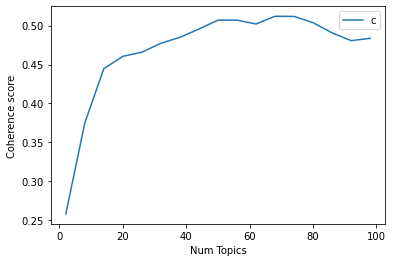

Wall time: 3min 56s


In [24]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)
# Show graph

limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
%%time

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=60)
lda_model.print_topics(num_topics=10, num_words=5)

Wall time: 8.37 s


[(5,
  '0.025*"россия" + 0.023*"сша" + 0.015*"заявить" + 0.010*"украина" + 0.009*"казахстан"'),
 (1,
  '0.025*"россия" + 0.009*"заявить" + 0.008*"украина" + 0.006*"президент" + 0.006*"путин"'),
 (28,
  '0.018*"путин" + 0.011*"россия" + 0.011*"сша" + 0.010*"российский" + 0.008*"украина"'),
 (6,
  '0.030*"россия" + 0.019*"путин" + 0.013*"сша" + 0.012*"безопасность" + 0.010*"казахстан"'),
 (37,
  '0.016*"россия" + 0.012*"сша" + 0.010*"украина" + 0.009*"путин" + 0.008*"европа"'),
 (27,
  '0.020*"россия" + 0.015*"украина" + 0.012*"путин" + 0.010*"рф" + 0.008*"заявить"'),
 (55,
  '0.045*"россия" + 0.020*"украина" + 0.018*"путин" + 0.014*"заявить" + 0.009*"сша"'),
 (30,
  '0.024*"россия" + 0.013*"украина" + 0.012*"рф" + 0.012*"заявить" + 0.011*"сша"'),
 (21,
  '0.017*"девятнадцать" + 0.016*"covid" + 0.016*"россия" + 0.012*"украина" + 0.011*"заявить"'),
 (38,
  '0.018*"заявить" + 0.014*"россия" + 0.011*"путин" + 0.010*"украина" + 0.008*"девятнадцать"')]

In [26]:
lda_model.print_topics(num_topics=10, num_words=5)

[(34,
  '0.027*"россия" + 0.011*"президент" + 0.010*"сша" + 0.009*"украина" + 0.008*"путин"'),
 (6,
  '0.030*"россия" + 0.019*"путин" + 0.013*"сша" + 0.012*"безопасность" + 0.010*"казахстан"'),
 (9,
  '0.015*"россия" + 0.009*"заявить" + 0.009*"европа" + 0.008*"covid" + 0.008*"девятнадцать"'),
 (28,
  '0.018*"путин" + 0.011*"россия" + 0.011*"сша" + 0.010*"российский" + 0.008*"украина"'),
 (24,
  '0.034*"россия" + 0.019*"заявить" + 0.017*"украина" + 0.013*"путин" + 0.010*"мид"'),
 (19,
  '0.024*"россия" + 0.021*"украина" + 0.015*"сша" + 0.009*"казахстан" + 0.009*"президент"'),
 (10,
  '0.020*"россия" + 0.012*"украина" + 0.009*"covid" + 0.009*"девятнадцать" + 0.009*"сша"'),
 (45,
  '0.032*"россия" + 0.016*"украина" + 0.013*"путин" + 0.010*"сша" + 0.009*"мид"'),
 (43,
  '0.017*"россия" + 0.013*"мид" + 0.013*"заявить" + 0.012*"украина" + 0.008*"москва"'),
 (7,
  '0.021*"сша" + 0.019*"россия" + 0.016*"украина" + 0.013*"заявить" + 0.009*"нато"')]

#### Визуализация

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24     0.006621  0.039259       1        1  2.309817
2      0.101217  0.018800       2        1  2.300501
33    -0.067594  0.177919       3        1  2.273472
55    -0.014926  0.086547       4        1  2.051498
42     0.208514 -0.021216       5        1  2.038041
47     0.163073  0.020742       6        1  2.002643
6      0.025029  0.115292       7        1  1.974302
51    -0.220673 -0.091305       8        1  1.973732
56    -0.152326  0.110153       9        1  1.929723
21     0.107331  0.221302      10        1  1.913549
19     0.109746  0.108554      11        1  1.888184
25    -0.025907  0.175385      12        1  1.887670
7     -0.223982  0.033437      13        1  1.839654
30    -0.124388  0.155344      14        1  1.835451
11    -0.016135 -0.062746      15        1  1.825351
22    -0.088317  0.128794      16        1  1.818060
14    -0.028088  0.016177      17        1  1.808098
16    -0.102525  0.022739      18        1  1.799528
45     0.028819  0.007908      19        1  1.797672
18     0.219447  0.075316      20        1  1.769801
13    -0.091343 -0.014723      21        1  1.748803
5      0.031449 -0.159231      22        1  1.745393
39     0.070378  0.153641      23        1  1.717544
58    -0.180714 -0.123595      24        1  1.690639
23    -0.067831 -0.060437      25        1  1.674352
36     0.059682 -0.067071      26        1  1.664147
54     0.126243 -0.056993      27        1  1.652262
43    -0.167772 -0.059693      28        1  1.641279
59     0.010780 -0.129517      29        1  1.641054
49    -0.065146 -0.184190      30        1  1.619786
44    -0.125912 -0.095946      31        1  1.613713
40     0.073939 -0.206146      32        1  1.613235
57    -0.180017 -0.002100      33        1  1.589063
8      0.183474 -0.121165      34        1  1.576893
37     0.089049 -0.085116      35        1  1.574435
38     0.214690  0.020604      36        1  1.570309
53     0.121216  0.062258      37        1  1.558157
35     0.104961 -0.177678      38        1  1.548377
52    -0.109004 -0.202807      39        1  1.535174
41    -0.094210 -0.135418      40        1  1.523769
34    -0.212410 -0.031972      41        1  1.519139
0     -0.205736  0.072888      42        1  1.514085
17    -0.015980 -0.247244      43        1  1.503752
1     -0.039522 -0.209575      44        1  1.499573
26     0.011804  0.182907      45        1  1.496012
20    -0.085422  0.084005      46        1  1.474296
28    -0.199479  0.139219      47        1  1.466094
10    -0.152001 -0.164751      48        1  1.463275
48     0.017410 -0.204066      49        1  1.463198
12     0.126477 -0.141539      50        1  1.410449
15     0.177486 -0.184550      51        1  1.410333
4      0.047942  0.193855      52        1  1.407458
29    -0.156629  0.050086      53        1  1.385223
27     0.135009  0.174470      54        1  1.383541
31    -0.099509  0.201684      55        1  1.379656
50    -0.021144  0.256749      56        1  1.363534
3      0.168034 -0.041753      57        1  1.353160
9      0.234826 -0.077925      58        1  1.342542
46     0.170278  0.099124      59        1  1.342516
32     0.189719  0.155312      60        1  1.287039, topic_info=              Term         Freq        Total Category  logprob  loglift
97           путин  1495.000000  1495.000000  Default  30.0000  30.0000
18          россия  3699.000000  3699.000000  Default  29.0000  29.0000
98         украина  2065.000000  2065.000000  Default  28.0000  28.0000
211   девятнадцать   690.000000   690.000000  Default  27.0000  27.0000
245      президент   965.000000   965.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
301           мочь     6.905048   527.682329  Topic60  -5.7057   0.0166
1285     погибнуть     5.984542   253.918389  Topic60  -5.8488   0.6050
28             фрг     